In [6]:
from threading import Lock
import span as sp
import time_stitching as tst
import pandas as pd
from IPython.display import display
from pprint import pprint
from sklearn.linear_model import LinearRegression
import time
import math
import matplotlib.pyplot as plt

latency_func = {}
is_trained_flag = False
complete_traces = {}
all_traces = {}
prerecorded_trace = {}
svc_to_rps = {}
endpoint_level_inflight = {}
endpoint_level_rps = {}
endpoint_to_cg_key = {}
ep_str_callgraph_table = {}
sp_callgraph_table = {}
all_endpoints = {}
placement = {}
coef_dict = {}
profiling = True
trace_str = list()
stats_mutex = Lock()
cluster_pcts = {}

In [17]:
global coef_dict
global placement
global all_endpoints
global endpoint_to_cg_key
global sp_callgraph_table
global ep_str_callgraph_table

ts = time.time()
filename = "./profiled_data/single_request_type_trace_string.csv"
# filename = "./profiled_data/slate_trace_string_reserve_only_.slatelog.csv"
# filename = "./profiled_data/slate_trace_string_recommend_only_.slatelog.csv"
# filename = "./profiled_data/slate_trace_string_user_only_.slatelog.csv"


col = ["cluster_id","svc_name","method","path","trace_id","span_id","parent_span_id","st","et","rt","xt","ct","call_size","inflight_dict","rps_dict"]

df = pd.read_csv(filename, names=col, header=None)
# span_df = df.iloc[:, :-2] # inflight_dict, rps_dict
# inflight_df = df.iloc[:, -2:-1] # inflight_dict, rps_dict
# rps_df = df.iloc[:, -1:] # inflight_dict, rps_dict
list_of_span = list()
# for (index1, span_df_row), (index2, inflight_df_row), (index2, rps_df_row) in zip(span_df.iterrows(), inflight_df.iterrows(), rps_df.iterrows()):
for index, row in df.iterrows():
    if row["cluster_id"] == "SLATE_UNKNOWN_REGION" or row["svc_name"] == "consul":
        continue
    # row: user-us-west-1@POST@/user.User/CheckUser:1|,user-us-west-1@POST@/user.User/CheckUser:14|
    # , is delimiter between rps_dict and inflight_dict
    # | is delimiter between two endpoints
    # @ is delimiter between svc_name @ method @ path
    
    num_inflight_dict = dict()
    rps_dict = dict()
    
    # inflight_row =  "user-us-west-1@POST@/user.User/CheckUser:1|user-us-west-1@POST@/user.User/CheckUser:1|"
    # print(row)
    # print(row["inflight_dict"])
    try:
        inflight_list = row["inflight_dict"].split("|")[:-1]
    except:
        print(f"row: {row}")
        print(f"row['inflight_dict']: {row['inflight_dict']}")
        continue
        # assert False
    for ep_inflight in inflight_list:
        # print(row)
        temp = ep_inflight.split(":")
        # print(f"len(temp): {len(temp)}")
        # print(temp)
        assert len(temp) == 2
        ep = temp[0] # user-us-west-1@POST@/user.User/CheckUser
        inflight = int(temp[1]) # 1
        svc_name = ep.split("@")[0]
        method = ep.split("@")[1]
        path = ep.split("@")[2]
        num_inflight_dict[ep] = inflight
        
    rps_list = row["rps_dict"].split("|")[:-1]
    for ep_rps in rps_list:
        temp = ep_rps.split(":")
        # print(f"len(temp): {len(temp)}")
        assert len(temp) == 2
        ep = temp[0] # user-us-west-1@POST@/user.User/CheckUser
        rps = int(temp[1]) # 1
        svc_name = ep.split("@")[0]
        method = ep.split("@")[1]
        path = ep.split("@")[2]
        rps_dict[ep] = rps
        
    span = sp.Span(row["method"], row["path"], row["svc_name"], row["cluster_id"], row["trace_id"], row["span_id"], row["parent_span_id"], st=float(row["st"]), et=float(row["et"]), callsize=int(row["call_size"]), rps_dict=rps_dict, num_inflight_dict=num_inflight_dict)
    list_of_span.append(span)
    # print(str(span))
    # exit()
    
# Convert list of span to traces data structure
traces = dict()
for span in list_of_span:
    if span.cluster_id not in traces:
        traces[span.cluster_id] = dict()
    if span.trace_id not in traces[span.cluster_id]:
        traces[span.cluster_id][span.trace_id] = list()
    traces[span.cluster_id][span.trace_id].append(span)

for cid in traces:
    tot_num_svc = 0
    for tid in traces[cid]:
        tot_num_svc += len(traces[cid][tid])
    avg_num_svc = tot_num_svc / len(traces[cid])
    print(f"avg_num_svc: {avg_num_svc}")
    
required_num_svc = math.ceil(avg_num_svc)

complete_traces = dict()
for cid in traces:
    if cid not in complete_traces:
        complete_traces[cid] = dict()
    for tid in traces[cid]:
        if len(traces[cid][tid]) == required_num_svc:
            complete_traces[cid][tid] = traces[cid][tid]
for cid in traces:
    print(f"len(traces[{cid}]): {len(traces[cid])}")
for cid in complete_traces:
    print(f"len(complete_traces[{cid}]): {len(complete_traces[cid])}")

print(f"FILE ==> DATA STRUCTURE: {int(time.time()-ts)} seconds")

row: cluster_id        @@@@@ update is 20240114_05:03:34
svc_name                                        NaN
method                                          NaN
path                                            NaN
trace_id                                        NaN
span_id                                         NaN
parent_span_id                                  NaN
st                                              NaN
et                                              NaN
rt                                              NaN
xt                                              NaN
ct                                              NaN
call_size                                       NaN
inflight_dict                                   NaN
rps_dict                                        NaN
Name: 37290, dtype: object
row['inflight_dict']: nan
row: cluster_id        @@@@@ update is 20240114_05:14:25
svc_name                                        NaN
method                                          NaN
p

In [24]:
def fit_linear_regression(data, y_col_name, svc_name, ep_str):
    df = pd.DataFrame(data)

    # Separate features and target
    x_colnames = list()
    for colname in df.columns:
        if colname != y_col_name:
            x_colnames.append(colname)
    X = df[x_colnames]
    y = df[y_col_name]
    
    '''Use this if you want preprocessing like normalization, standardization, etc.'''
    # Standardize features using StandardScaler
    # scaler = StandardScaler()
    # X = scaler.fit_transform(X)

    # Create and fit a linear regression model on standardized features
    model = LinearRegression()
    model.fit(X, y)
    
    feature_names =  list(X.columns)+ ['intercept']

    # Create a DataFrame with coefficients and feature names
    coefficients_df = pd.DataFrame(\
            {'Feature': feature_names, \
            'Coefficient':  list(model.coef_)+[model.intercept_]}\
        )

    # Display the coefficients DataFrame
    coef = dict()
    for index, row in coefficients_df.iterrows():
        # if row['Coefficient'] < 0:
        #     print(row)
        #     print(f"ERROR: row['Coefficient'] < 0: {row['Coefficient']}")
        #     assert False
        coef[row['Feature']] = row['Coefficient']
        
    
    # plot
    # y = ax + b
    key_for_coef = list()
    for key in coef:
        if key == 'intercept':
            b = coef[key]
        else:
            key_for_coef.append(key)
    a = coef[key_for_coef[0]]
    x_list = [0, 100]
    y_list = list()
    for x in x_list:
        y_list.append(a*x+b)
    plt.plot(X, y, 'bo', alpha=0.4)
    plt.plot(x_list, y_list, color='red', linewidth=2)
    plt.xlabel('inflight_req')
    plt.ylabel('exclusive time (ms)')
    plt.title(svc_name + " / " + ep_str)
    # plt.savefig(f"latency_{ep_str}.pdf")
    plt.show()
    return coef

In [19]:
'''Time stitching'''
stitched_traces = tst.stitch_time(complete_traces)


'''Create useful data structures from the traces'''
sp_callgraph_table = tst.traces_to_span_callgraph_table(stitched_traces)
endpoint_to_cg_key = tst.get_endpoint_to_cg_key_map(stitched_traces)
ep_str_callgraph_table = tst.traces_to_endpoint_str_callgraph_table(stitched_traces)
print("ep_str_callgraph_table")
print(f"num different callgraph: {len(ep_str_callgraph_table)}")
for cg_key in ep_str_callgraph_table:
    print(f"{cg_key}: {ep_str_callgraph_table[cg_key]}")
all_endpoints = tst.get_all_endpoints(stitched_traces)
for cid in all_endpoints:
    for svc_name in all_endpoints[cid]:
        print(f"all_endpoints[{cid}][{svc_name}]: {all_endpoints[cid][svc_name]}")
tst.file_write_callgraph_table(sp_callgraph_table)
placement = tst.get_placement_from_trace(stitched_traces)
for cid in placement:
    print(f"placement[{cid}]: {placement[cid]}")


'''
Train linear regression model
The linear regression model is function of "inflight_req"
'''

df = tst.trace_to_df(traces)

new callgraph key: frontend-us-west-1@POST@/reservation@reservation-us-west-1@POST@/reservation.Reservation/MakeReservation@user-us-west-1@POST@/user.User/CheckUser in cluster us-west-1
new callgraph key: frontend-us-west-1@GET@/recommendations@profile-us-west-1@POST@/profile.Profile/GetProfiles@recommendation-us-west-1@POST@/recommendation.Recommendation/GetRecommendations in cluster us-west-1
new callgraph key: frontend-us-west-1@POST@/reservation@reservation-us-west-1@POST@/reservation.Reservation/MakeReservation@user-us-west-1@POST@/user.User/CheckUser in cluster us-west-1
new callgraph key: frontend-us-west-1@GET@/recommendations@profile-us-west-1@POST@/profile.Profile/GetProfiles@recommendation-us-west-1@POST@/recommendation.Recommendation/GetRecommendations in cluster us-west-1
ep_str_callgraph_table
num different callgraph: 2
frontend-us-west-1@POST@/reservation@reservation-us-west-1@POST@/reservation.Reservation/MakeReservation@user-us-west-1@POST@/user.User/CheckUser: {'front

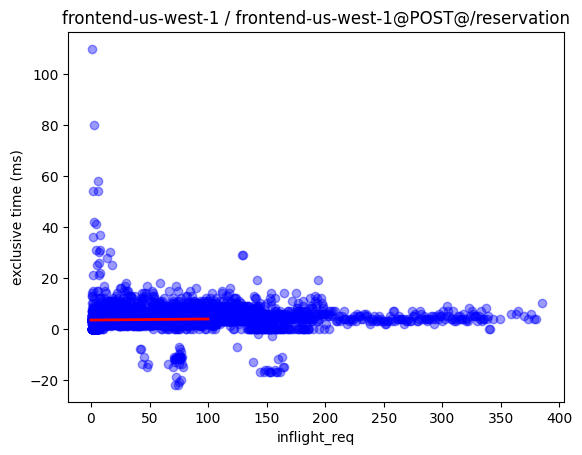

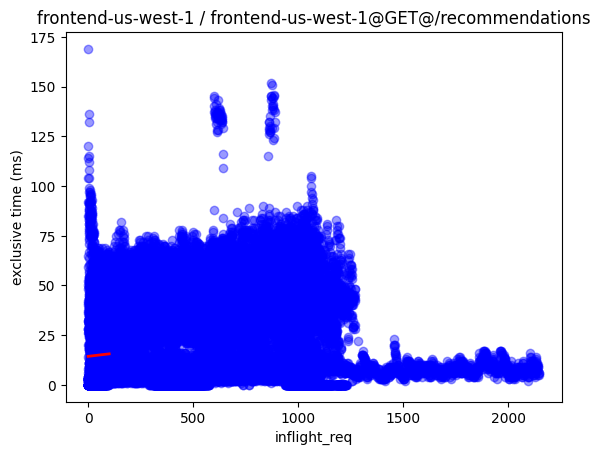

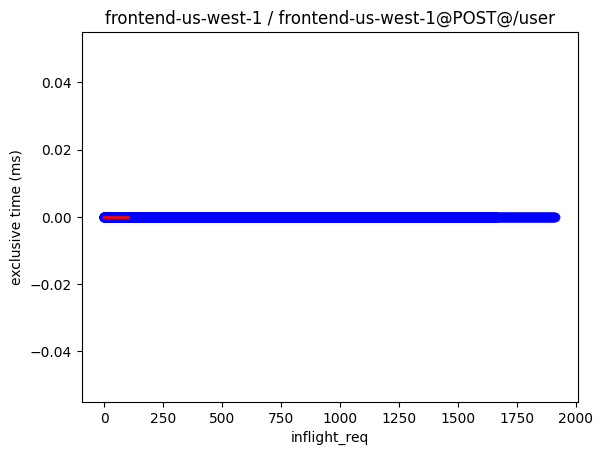

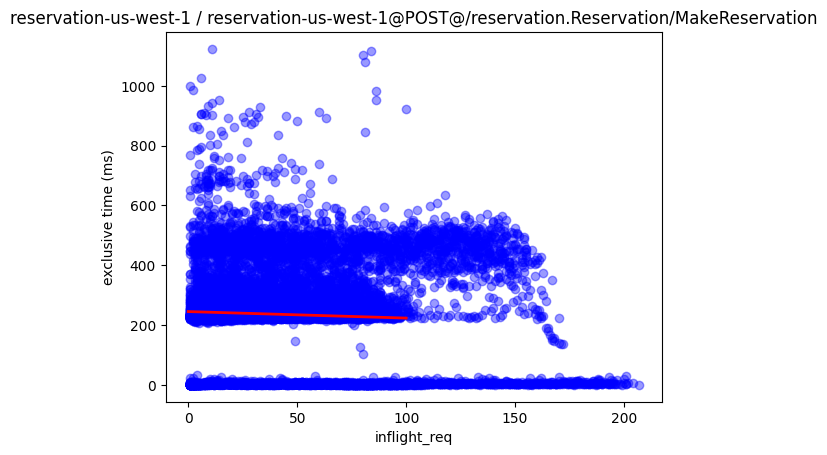

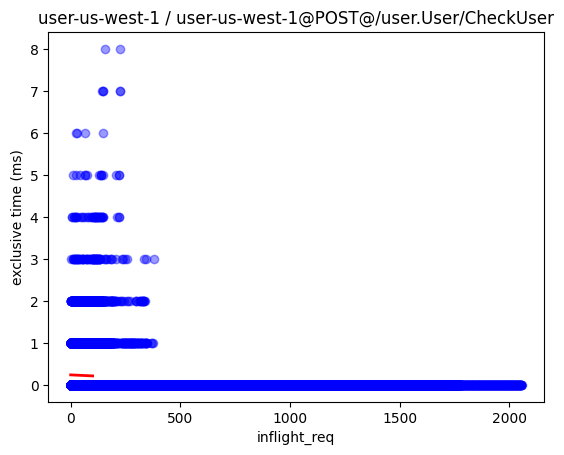

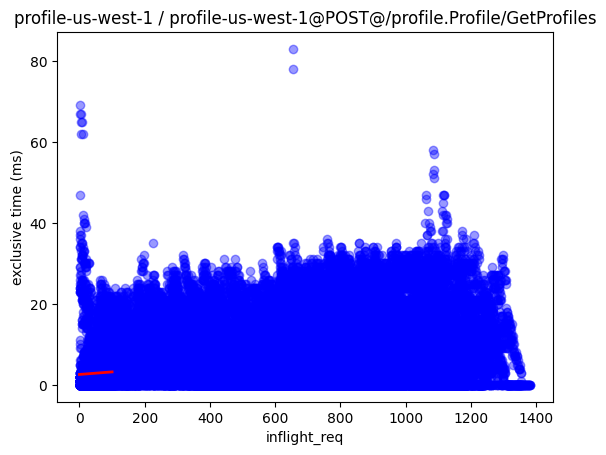

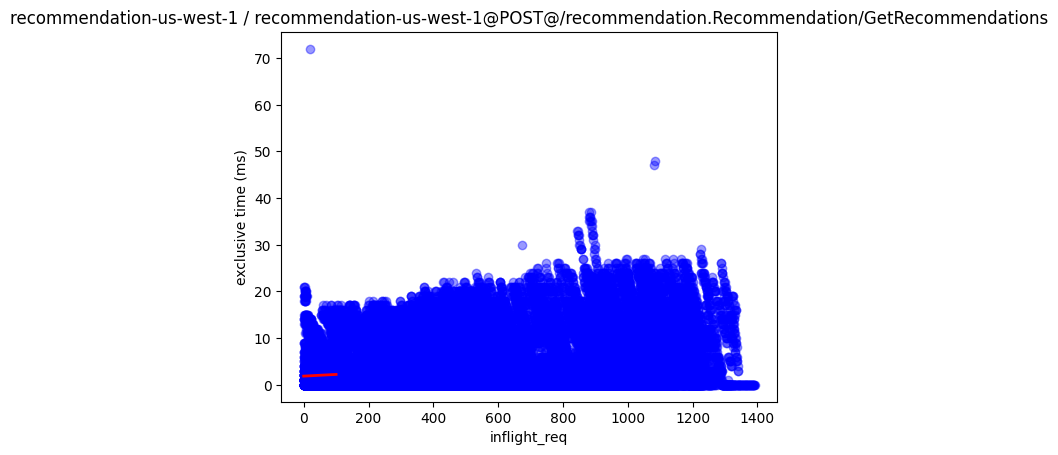

coef_dict[frontend-us-west-1][frontend-us-west-1@POST@/reservation]: {'frontend-us-west-1@POST@/reservation': 0.004162879172829664, 'intercept': 3.4341323444861827}
coef_dict[frontend-us-west-1][frontend-us-west-1@GET@/recommendations]: {'frontend-us-west-1@GET@/recommendations': 0.012465183782993761, 'intercept': 14.310421028632197}
coef_dict[frontend-us-west-1][frontend-us-west-1@POST@/user]: {'frontend-us-west-1@POST@/user': 0.0, 'intercept': 0.0}
coef_dict[reservation-us-west-1][reservation-us-west-1@POST@/reservation.Reservation/MakeReservation]: {'reservation-us-west-1@POST@/reservation.Reservation/MakeReservation': -0.21747782362530602, 'intercept': 244.88002601582423}
coef_dict[user-us-west-1][user-us-west-1@POST@/user.User/CheckUser]: {'user-us-west-1@POST@/user.User/CheckUser': -0.00024611970349960947, 'intercept': 0.23578414427983158}
coef_dict[profile-us-west-1][profile-us-west-1@POST@/profile.Profile/GetProfiles]: {'profile-us-west-1@POST@/profile.Profile/GetProfiles': 0.0

In [25]:
for cid in df["cluster_id"].unique():
    cid_df = df[df["cluster_id"]==cid]
    for svc_name in cid_df["svc_name"].unique():
        cid_svc_df = cid_df[cid_df["svc_name"]==svc_name]
        if svc_name not in latency_func:
            latency_func[svc_name] = dict()
        if svc_name not in coef_dict:
            coef_dict[svc_name] = dict()
        for ep_str in cid_svc_df["endpoint_str"].unique():
            ep_df = cid_svc_df[cid_svc_df["endpoint_str"]==ep_str]
            # Data preparation: load(X) and latency(y) 
            data = dict()
            y_col = "latency"
            for index, row in ep_df.iterrows():
                ###############################################
                # for key, val in row["num_inflight_dict"].items():
                for key, val in row["rps_dict"].items():
                ################################################
                    if key not in data:
                        data[key] = list()
                    data[key].append(val)
                if y_col not in data:
                    data[y_col] = list()
                data[y_col].append(row["xt"])
            coef_dict[svc_name][ep_str] = fit_linear_regression(data, y_col, svc_name, ep_str)

for svc_name in coef_dict:
    for ep_str in coef_dict[svc_name]:
        print(f'coef_dict[{svc_name}][{ep_str}]: {coef_dict[svc_name][ep_str]}')

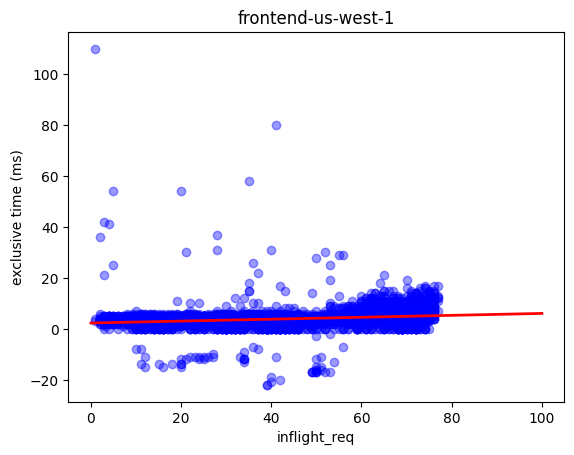

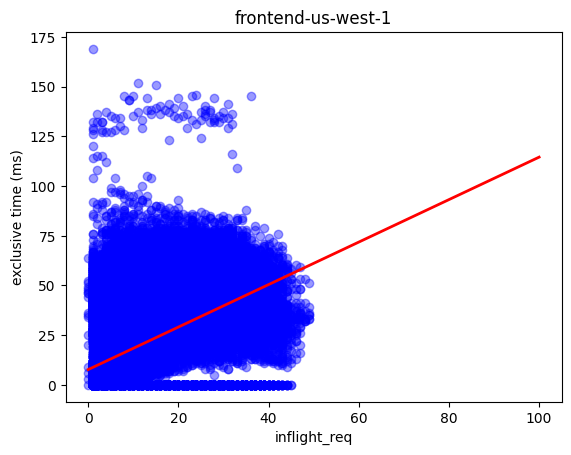

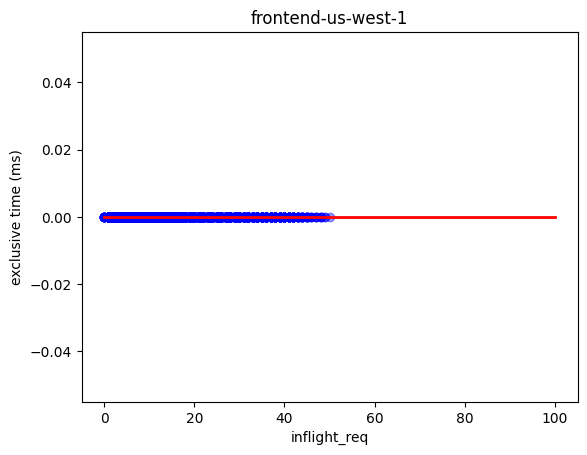

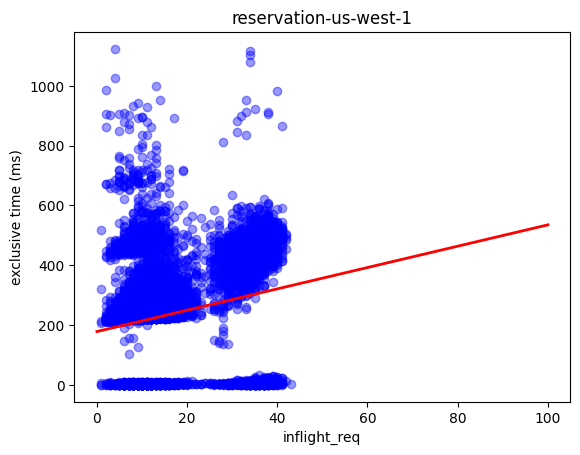

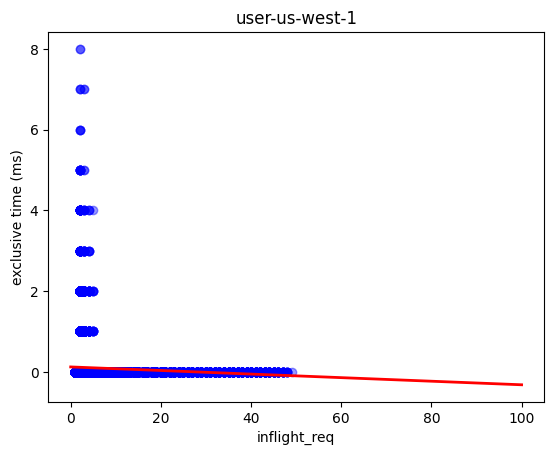

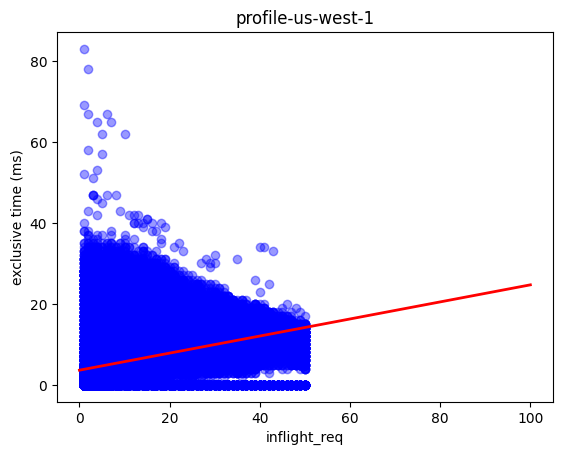

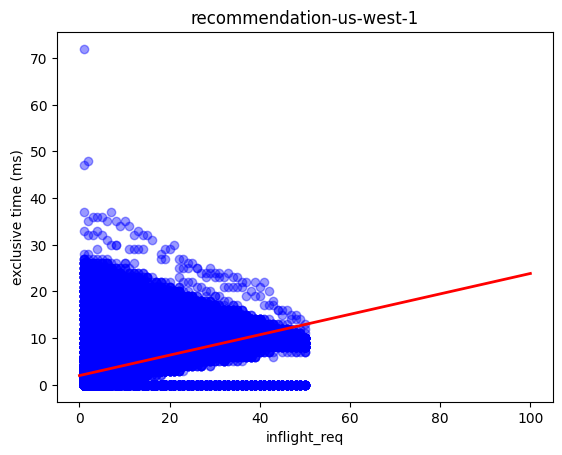

coef_dict[frontend-us-west-1][frontend-us-west-1@POST@/reservation]: {'frontend-us-west-1@POST@/reservation': 0.03765232738843581, 'intercept': 2.267383425113094}
coef_dict[frontend-us-west-1][frontend-us-west-1@GET@/recommendations]: {'frontend-us-west-1@GET@/recommendations': 1.0683982367973595, 'intercept': 7.660641793647059}
coef_dict[frontend-us-west-1][frontend-us-west-1@POST@/user]: {'frontend-us-west-1@POST@/user': 0.0, 'intercept': 0.0}
coef_dict[reservation-us-west-1][reservation-us-west-1@POST@/reservation.Reservation/MakeReservation]: {'reservation-us-west-1@POST@/reservation.Reservation/MakeReservation': 3.568993932637442, 'intercept': 178.1202388191693}
coef_dict[user-us-west-1][user-us-west-1@POST@/user.User/CheckUser]: {'user-us-west-1@POST@/user.User/CheckUser': -0.0044216909262699295, 'intercept': 0.11897267845377968}
coef_dict[profile-us-west-1][profile-us-west-1@POST@/profile.Profile/GetProfiles]: {'profile-us-west-1@POST@/profile.Profile/GetProfiles': 0.21078801931

In [21]:
for cid in df["cluster_id"].unique():
    cid_df = df[df["cluster_id"]==cid]
    for svc_name in cid_df["svc_name"].unique():
        cid_svc_df = cid_df[cid_df["svc_name"]==svc_name]
        if svc_name not in latency_func:
            latency_func[svc_name] = dict()
        if svc_name not in coef_dict:
            coef_dict[svc_name] = dict()
        for ep_str in cid_svc_df["endpoint_str"].unique():
            ep_df = cid_svc_df[cid_svc_df["endpoint_str"]==ep_str]
            # Data preparation: load(X) and latency(y) 
            data = dict()
            y_col = "latency"
            for index, row in ep_df.iterrows():
                ###############################################
                for key, val in row["num_inflight_dict"].items():
                # for key, val in row["rps_dict"].items():
                ################################################
                    if key not in data:
                        data[key] = list()
                    data[key].append(val)
                if y_col not in data:
                    data[y_col] = list()
                data[y_col].append(row["xt"])
            coef_dict[svc_name][ep_str] = fit_linear_regression(data, y_col, svc_name)

for svc_name in coef_dict:
    for ep_str in coef_dict[svc_name]:
        print(f'coef_dict[{svc_name}][{ep_str}]: {coef_dict[svc_name][ep_str]}')